In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [24]:
data = pd.read_excel('/content/data.xlsx', header=0)
data

,№,q1,q2,psi 1,psi2,u1,u2,tau
0,1,0.0,0.0,0.0,1.0,0.905792,0.355074,0.000000
1,2,0.0,0.2,0.0,1.0,0.780610,1.000000,0.102020
2,3,0.0,0.4,0.0,1.0,0.477081,1.000000,0.104081
3,4,0.0,0.6,0.0,1.0,0.041391,1.000000,0.106184
4,5,0.0,0.8,0.0,1.0,0.356194,1.000000,0.108329
...,...,...,...,...,...,...,...,...
251,252,3.0,2.2,0.7,0.3,0.474250,0.678017,0.255086
252,253,3.0,2.4,0.6,0.4,0.513185,0.612232,0.272458
253,254,3.0,2.6,0.6,0.4,0.513308,0.613170,0.293111
254,255,3.0,2.8,0.5,0.5,0.560004,0.558688,0.327780


## Изучение данных

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   №       256 non-null    int64  
 1   q1      256 non-null    float64
 2   q2      256 non-null    float64
 3   psi 1   256 non-null    float64
 4   psi2    256 non-null    float64
 5   u1      256 non-null    float64
 6   u2      256 non-null    float64
 7   tau     256 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 16.1 KB


In [26]:
q1 = data['q1']
q2 = data['q2']
psi1 = data['psi 1']
u1 = data['u1']
u2 = data['u2']

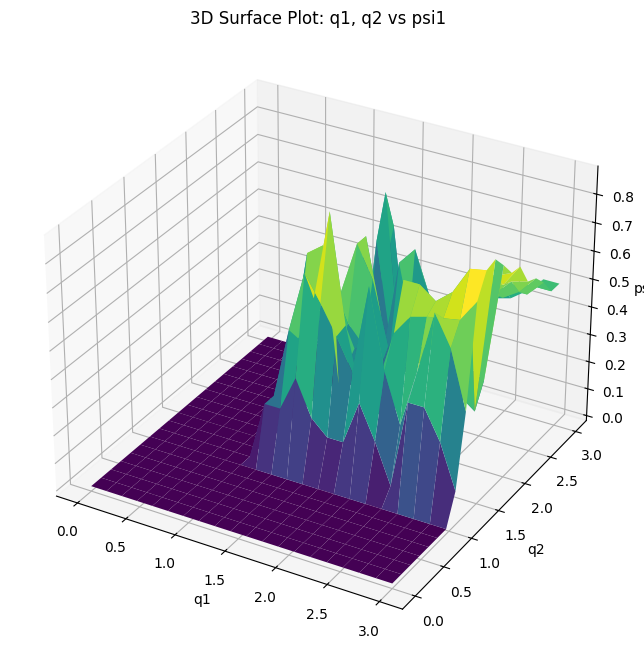

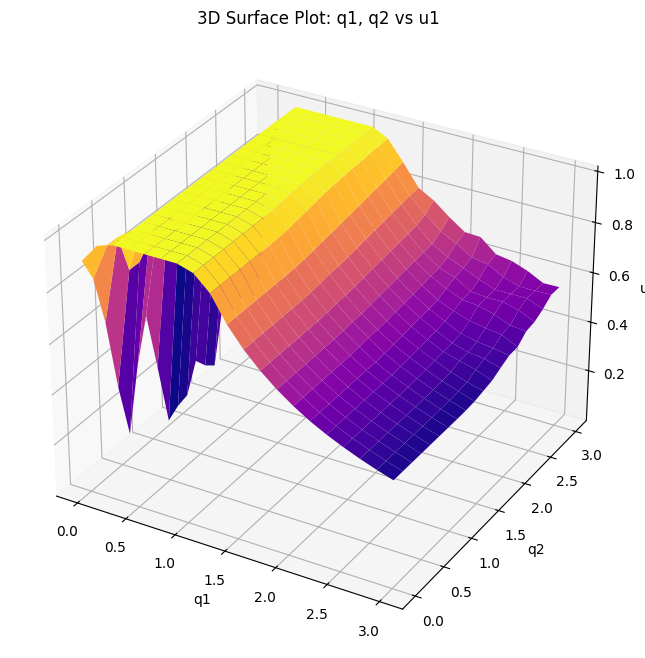

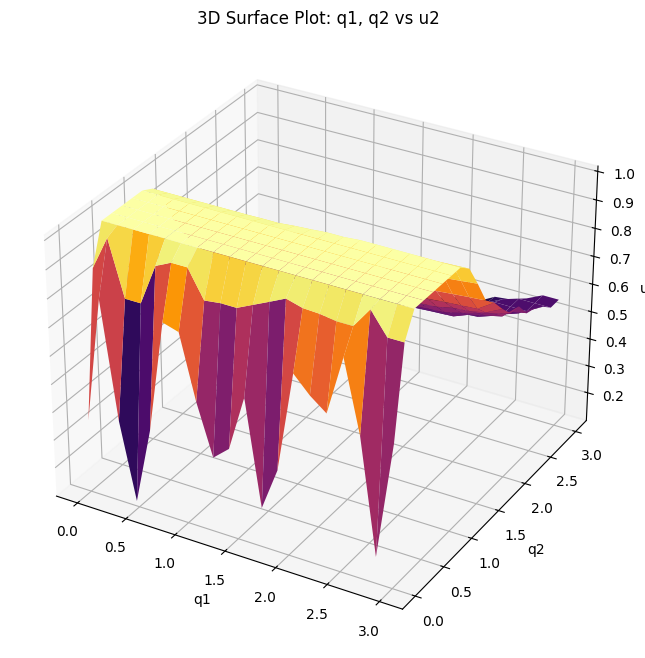

In [27]:
# Для 3D графиков создадим сетку значений q1 и q2
q1_grid, q2_grid = np.meshgrid(np.linspace(min(q1), max(q1), 20),
                               np.linspace(min(q2), max(q2), 20))

# Интерполируем данные, чтобы получить значения на сетке
from scipy.interpolate import griddata

# Интерполяция данных для каждой поверхности
psi1_grid = griddata((q1, q2), psi1, (q1_grid, q2_grid), method='linear')
u1_grid = griddata((q1, q2), u1, (q1_grid, q2_grid), method='linear')
u2_grid = griddata((q1, q2), u2, (q1_grid, q2_grid), method='linear')

# График 1: 3D поверхность, q1, q2 - плоскость, psi1 - высота
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, psi1_grid, cmap='viridis')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('psi1')
ax.set_title('3D Surface Plot: q1, q2 vs psi1')
plt.show()

# График 2: 3D поверхность, q1, q2 - плоскость, u1 - высота
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, u1_grid, cmap='plasma')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('u1')
ax.set_title('3D Surface Plot: q1, q2 vs u1')
plt.show()

# График 3: 3D поверхность, q1, q2 - плоскость, u2 - высота
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, u2_grid, cmap='inferno')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('u2')
ax.set_title('3D Surface Plot: q1, q2 vs u2')
plt.show()



In [28]:
X = data[['q1', 'q2']].values
y = data[['psi 1', 'u1', 'u2']].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
print("Feature matrix:", x_train.shape)
print("Target matrix:", x_test.shape)
print("Feature matrix:", y_train.shape)
print("Target matrix:", y_test.shape)

Feature matrix: (179, 2)
Target matrix: (77, 2)
Feature matrix: (179, 3)
Target matrix: (77, 3)


## Построение модели

Последовательная модель позволяет нам создавать модели послойно.
Первые два плотных слоя используются для создания полностью связанной модели и являются скрытыми слоями.
Последний плотный слой - это выходной слой, который решает, к какой категории относится данное данное сочетание.

In [30]:
hid_size = 64

model = Sequential([
    Dense(hid_size, activation='relu', input_shape=(2,)),  # Входной слой с 2 входами
    Dense(hid_size, activation="relu"), # y^2
    Dense(hid_size, activation="relu"), # y^3
    Dense(3, activation='sigmoid') # Выходной слой
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Компиляция модели

In [31]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=Huber(delta=1.0), metrics=['mae', 'accuracy'])

In [32]:
weights = model.get_weights()
#weights

In [33]:
history = model.fit(x_train, y_train, epochs=600,
          batch_size=32,
          validation_split=0.1,
          verbose=0)
          # verbose=1)


Предсказания

In [34]:
y_pred = model.predict(x_test)
weights = model.get_weights()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Максимальная ошибка:
psi1_diff    0.634718
u1_diff      0.584305
u2_diff      0.886398
dtype: float64


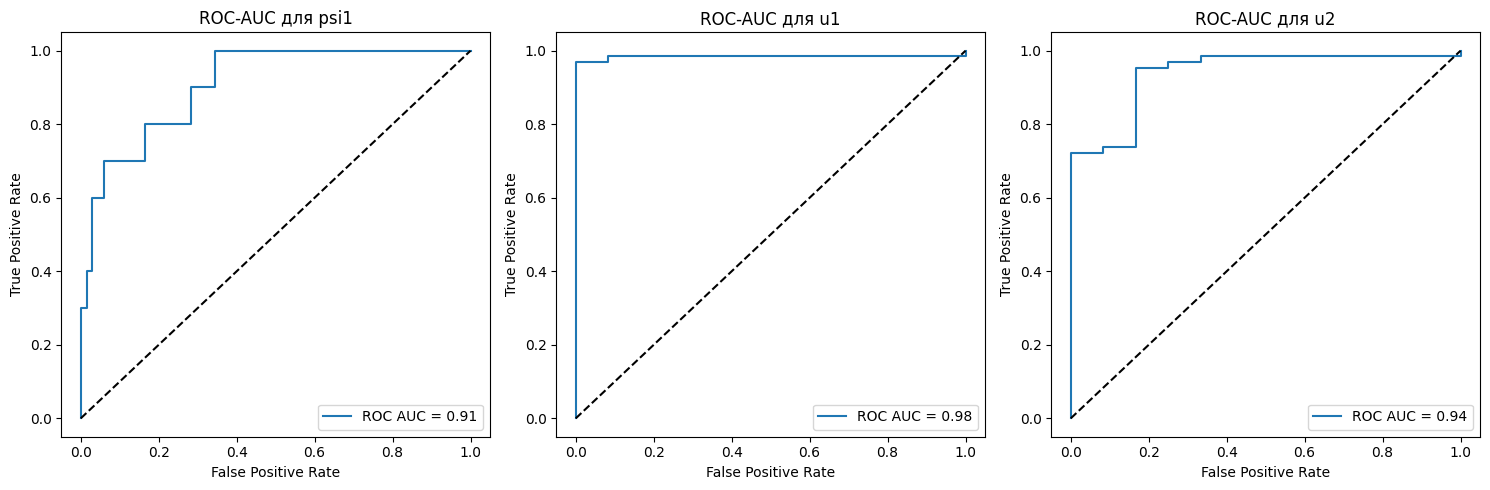

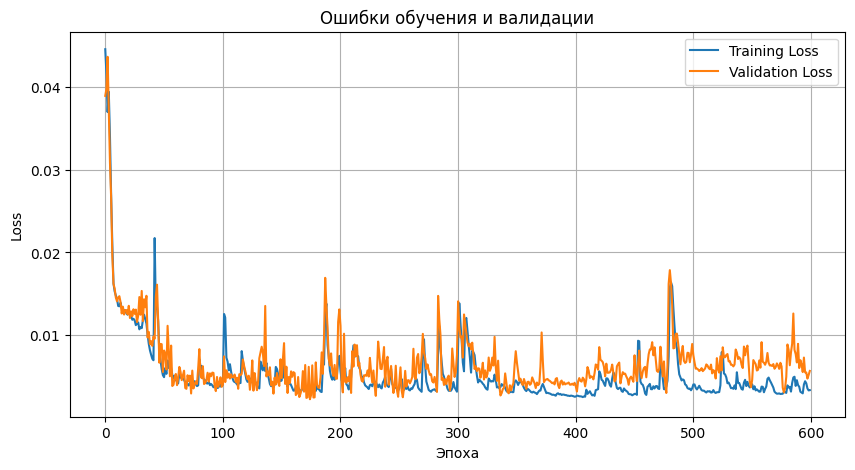

In [35]:
# Формируем таблицу с результатами
results = pd.DataFrame({
    "q1": x_test[:, 0],
    "q2": x_test[:, 1],
    "psi1": y_test[:, 0],
    "u1": y_test[:, 1],
    "u2": y_test[:, 2],
    "psi1_pred": y_pred[:, 0],
    "u1_pred": y_pred[:, 1],
    "u2_pred": y_pred[:, 2],
})


results["psi1_diff"] = np.abs(results["psi1"] - results["psi1_pred"])
results["u1_diff"] = np.abs(results["u1"] - results["u1_pred"])
results["u2_diff"] = np.abs(results["u2"] - results["u2_pred"])

# Вывод максимальной ошибки
max_errors = results[["psi1_diff", "u1_diff", "u2_diff"]].max()
print("Максимальная ошибка:")
print(max_errors)

# Построение графика ROC-AUC
plt.figure(figsize=(15, 5))

for i, (test_col, pred_col) in enumerate([("psi1", "psi1_pred"), ("u1", "u1_pred"), ("u2", "u2_pred")]):
    # ROC-AUC для каждой величины
    fpr, tpr, _ = roc_curve(results[test_col] > 0.5, results[pred_col])
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 3, i + 1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC-AUC для {test_col}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

plt.tight_layout()
plt.show()

# График ошибки на эпохах
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Ошибки обучения и валидации')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Данные из результатов
q1_pred = results["q1"]
q2_pred = results["q2"]
psi1_pred = results["psi1_pred"]
u1_pred = results["u1_pred"]
u2_pred = results["u2_pred"]

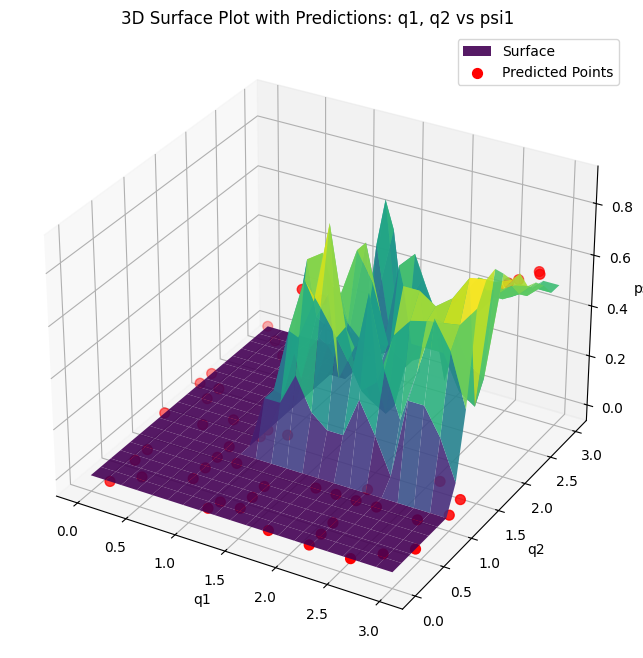

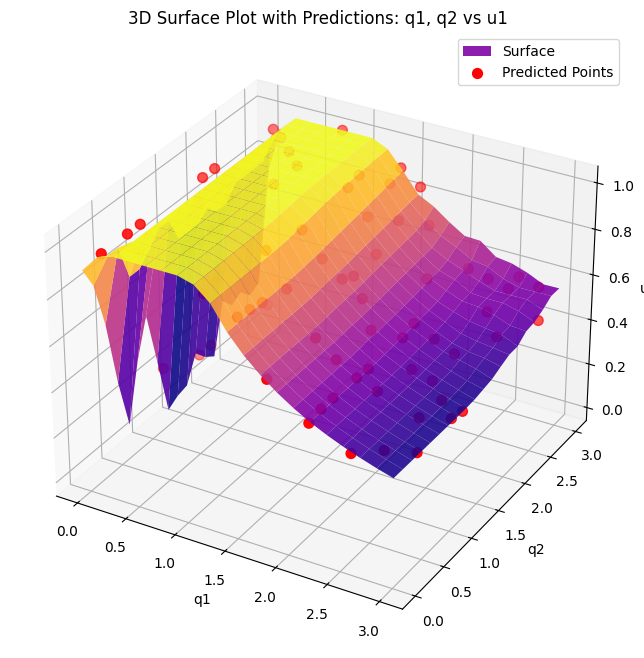

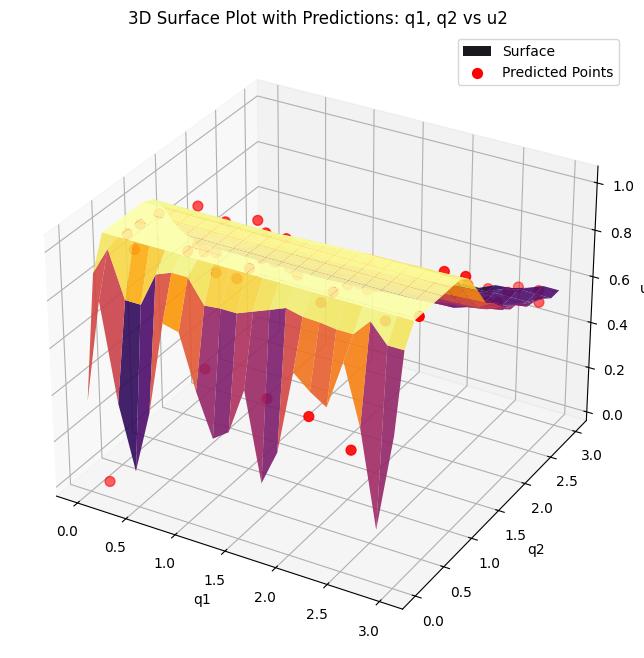

In [37]:
# Сетка для поверхности
q1_grid, q2_grid = np.meshgrid(
    np.linspace(min(q1), max(q1), 20),
    np.linspace(min(q2), max(q2), 20)
)

# Интерполяция данных для построения поверхностей
psi1_grid = griddata((q1, q2), psi1, (q1_grid, q2_grid), method='linear')
u1_grid = griddata((q1, q2), u1, (q1_grid, q2_grid), method='linear')
u2_grid = griddata((q1, q2), u2, (q1_grid, q2_grid), method='linear')

# График 1: psi1
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, psi1_grid, cmap='viridis', alpha=0.9, label='Surface')
ax.scatter(q1_pred, q2_pred, psi1_pred, color='red', s=50, label='Predicted Points')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('psi1')
ax.set_title('3D Surface Plot with Predictions: q1, q2 vs psi1')
ax.legend()
plt.show()

# График 2: u1
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, u1_grid, cmap='plasma', alpha=0.9, label='Surface')
ax.scatter(q1_pred, q2_pred, u1_pred, color='red', s=50, label='Predicted Points')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('u1')
ax.set_title('3D Surface Plot with Predictions: q1, q2 vs u1')
ax.legend()
plt.show()

# График 3: u2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1_grid, q2_grid, u2_grid, cmap='inferno', alpha=0.9, label='Surface')
ax.scatter(q1_pred, q2_pred, u2_pred, color='red', s=50, label='Predicted Points')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('u2')
ax.set_title('3D Surface Plot with Predictions: q1, q2 vs u2')
ax.legend()
plt.show()

In [38]:
y_test[12]

array([0.7       , 0.44436712, 1.        ])

In [39]:
y_pred[12]

array([0.06528176, 0.4427252 , 0.9892781 ], dtype=float32)

## Экспорт данных

In [40]:
# Сохранение в Excel
columns_to_export = ['q1', 'q2', 'psi1', 'u1', 'u2', 'psi1_pred', 'u1_pred', 'u2_pred']
results[columns_to_export].to_excel("results.xlsx", sheet_name='Sheet_1', index=False)

print("Результаты успешно экспортированы в файл results.xlsx")


Результаты успешно экспортированы в файл results.xlsx


## Мультистарт

In [41]:
# Гиперпараметры
hid_size = 64
num_starts = 5
learning_rate = 0.001
epochs = 600
batch_size = 32

In [42]:
# Функция для создания модели
def create_model():
    model = Sequential([
        Dense(hid_size, activation='relu', input_shape=(2,)),  # Входной слой
        Dense(hid_size, activation='relu'),                   # Скрытый слой
        Dense(hid_size, activation='relu'),                   # Скрытый слой
        Dense(3, activation='sigmoid')                        # Выходной слой
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=MeanSquaredError(),
                  metrics=['mse'])  # Добавляем MSE как метрику
    return model

# Словарь для сохранения результатов
models_results = {}

for i in range(num_starts):
    print(f"Запуск {i + 1}/{num_starts}")
    model = create_model()
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)

    # Сохраняем результаты (модель и ошибка на валидации)
    val_mse = history.history['val_mse'][-1]  # MSE на последней эпохе
    models_results[i] = {
        'model': model,
        'val_mse': val_mse
    }
    print(f"MSE на валидации для запуска {i + 1}: {val_mse:.8f}")

# Выбираем модель с наименьшим значением MSE
best_model_index = min(models_results, key=lambda k: models_results[k]['val_mse'])
best_model = models_results[best_model_index]['model']
print(f"Лучшая модель из запуска {best_model_index + 1} с MSE {models_results[best_model_index]['val_mse']:.8f}")


Запуск 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE на валидации для запуска 1: 0.01214479
Запуск 2/5
MSE на валидации для запуска 2: 0.01267176
Запуск 3/5
MSE на валидации для запуска 3: 0.01206486
Запуск 4/5
MSE на валидации для запуска 4: 0.01273268
Запуск 5/5
MSE на валидации для запуска 5: 0.01210972
Лучшая модель из запуска 3 с MSE 0.01206486


In [43]:
import os

# Путь для сохранения модели
save_path = "best_model.h5"

# Сохраняем лучшую модель
best_model.save(save_path)
print(f"Лучшая модель сохранена в {os.path.abspath(save_path)}")


Лучшая модель сохранена в /content/best_model.h5
